# 1. Create a toy density

<IPython.core.display.Javascript object>


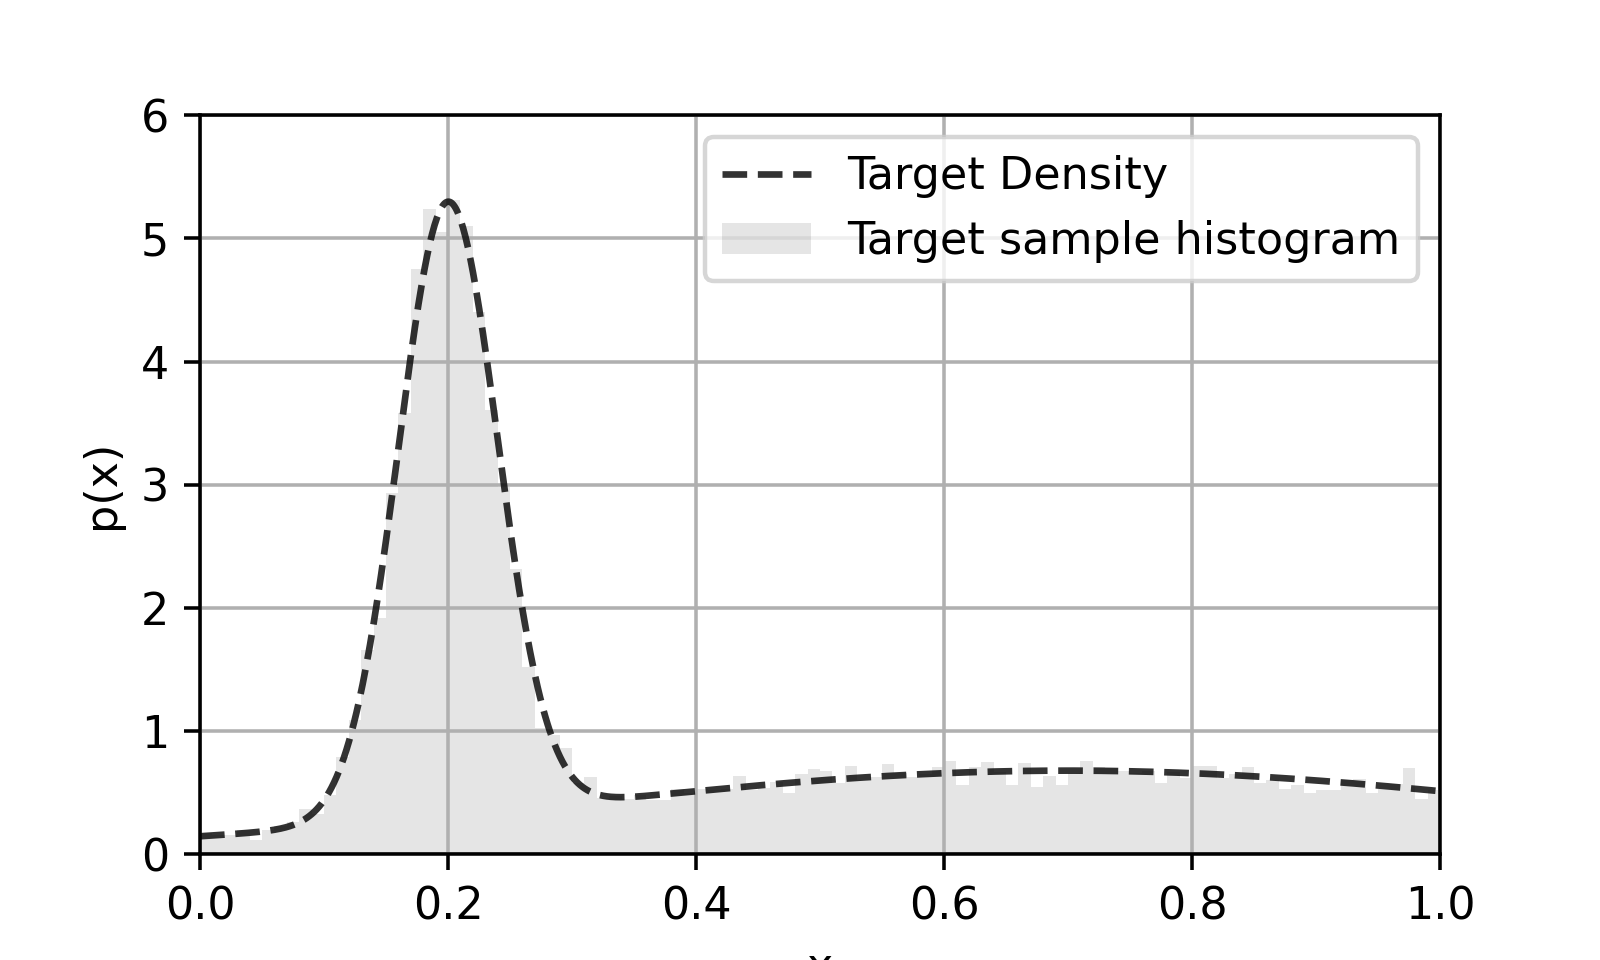

In [1]:
%matplotlib notebook

from functools import partial
import jax
import optax
import distrax
from distrax import Normal
import matplotlib.pyplot as plt

import jax.numpy as jnp

# create a mixture of two Truncated Gaussians with a support of [0, 1]
class TruncatedNormal:
    def __init__(self, mean, scale):
        self.mean = mean
        self.scale = scale

        self.d = Normal(mean, scale)

        self.l_cdf = jax.scipy.stats.norm.cdf(jnp.zeros_like(mean), mean, scale)
        self.r_cdf = jax.scipy.stats.norm.cdf(jnp.ones_like(mean), mean, scale)
        
        self.log_z = jnp.log(self.r_cdf - self.l_cdf)

    def sample(self, key, shape):
        u = jax.random.uniform(key, shape + self.mean.shape) * (self.r_cdf - self.l_cdf) + self.l_cdf
        x = jax.scipy.stats.norm.ppf(u, self.mean, self.scale)
        us = jnp.clip(x, 0., 1.)
        return us

    def log_prob(self, x):
        return self.d.log_prob(x) - self.log_z

g1 = TruncatedNormal(jnp.array(0.2), jnp.array(0.04))
g2 = TruncatedNormal(jnp.array(0.7), jnp.array(0.4))

# sampling functions
@partial(jax.jit, static_argnames=['shape', 'g1', 'g2'])
def sample_mixture(key, shape, g1, g2):
    key1, key2, key3 = jax.random.split(key, 3)
    s1, s2 = g1.sample(key1, shape), g2.sample(key2, shape)
    mask = (jax.random.uniform(key3, shape) < 0.5).astype(float)
    
    return s1 * mask + s2 * (1. - mask)

# probability density computation
def compute_prob(x):
    return (jnp.exp(g1.log_prob(x)) + jnp.exp(g2.log_prob(x))) / 2.

def visualize(key, ax, plot_adacat=False, params=None):
    ax.clear()
    
    xs = jnp.linspace(0., 1., 1000)
    p_prob = compute_prob(xs)
    ps = sample_mixture(key, (10000,), g1, g2)
    ax.plot(xs, p_prob,    "--", color="black", alpha=0.80, label="Target Density")
    ax.hist(ps, range=(0., 1.), density=True, color="black", alpha=0.10, label="Target sample histogram", bins=100)
    
    if plot_adacat:
        q = Adacat(params["w_logits"], params["h_logits"])
        q_prob = q.prob(xs)
        qs = q.sample(seed=key, sample_shape=(10000,))
    
        ax.plot(xs, q_prob,    "-",  color="blue",  alpha=0.80, label="AdaCat analytic density")
        ax.hist(qs, range=(0., 1.), density=True, color="blue", alpha=0.10, label="AdaCat sample histogram", bins=100)

    ax.set_ylim(0., 6.)
    ax.set_xlim(0., 1.)
    ax.set_ylabel("p(x)")
    ax.set_xlabel("x")
    ax.grid()
    ax.legend()
    

# let's visualize the target density
key = jax.random.PRNGKey(0)

fig, ax = plt.subplots(figsize=(5, 3), dpi=160)
visualize(key, ax)

# 2. Define an Adacat distribution

<IPython.core.display.Javascript object>


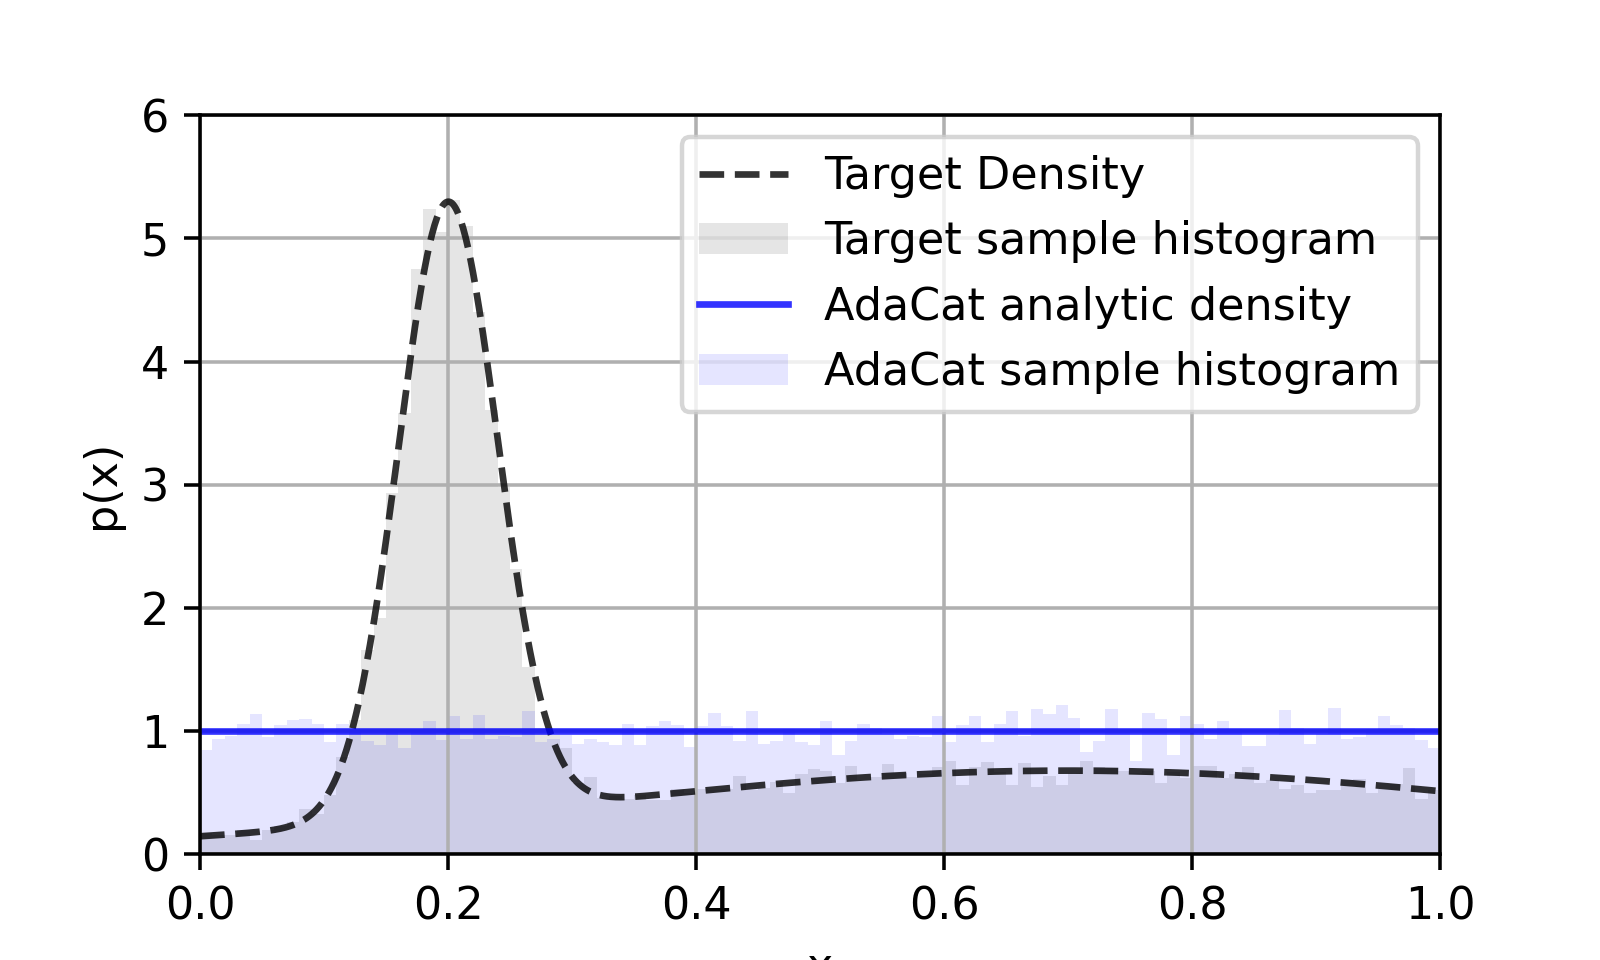

In [2]:
from adacat.jax import Adacat

# create parameters for the Adacat distribution and try to fit to the mixture of g1 and g2
k = 10  # use 10 components
params = {'w_logits': jnp.zeros((k,)), 'h_logits': jnp.zeros((k,))}

fig, ax = plt.subplots(figsize=(5, 3), dpi=160)
visualize(key, ax, True, params)

# 3. Optimize the Adacat Distribution to Match the Toy Density

<IPython.core.display.Javascript object>


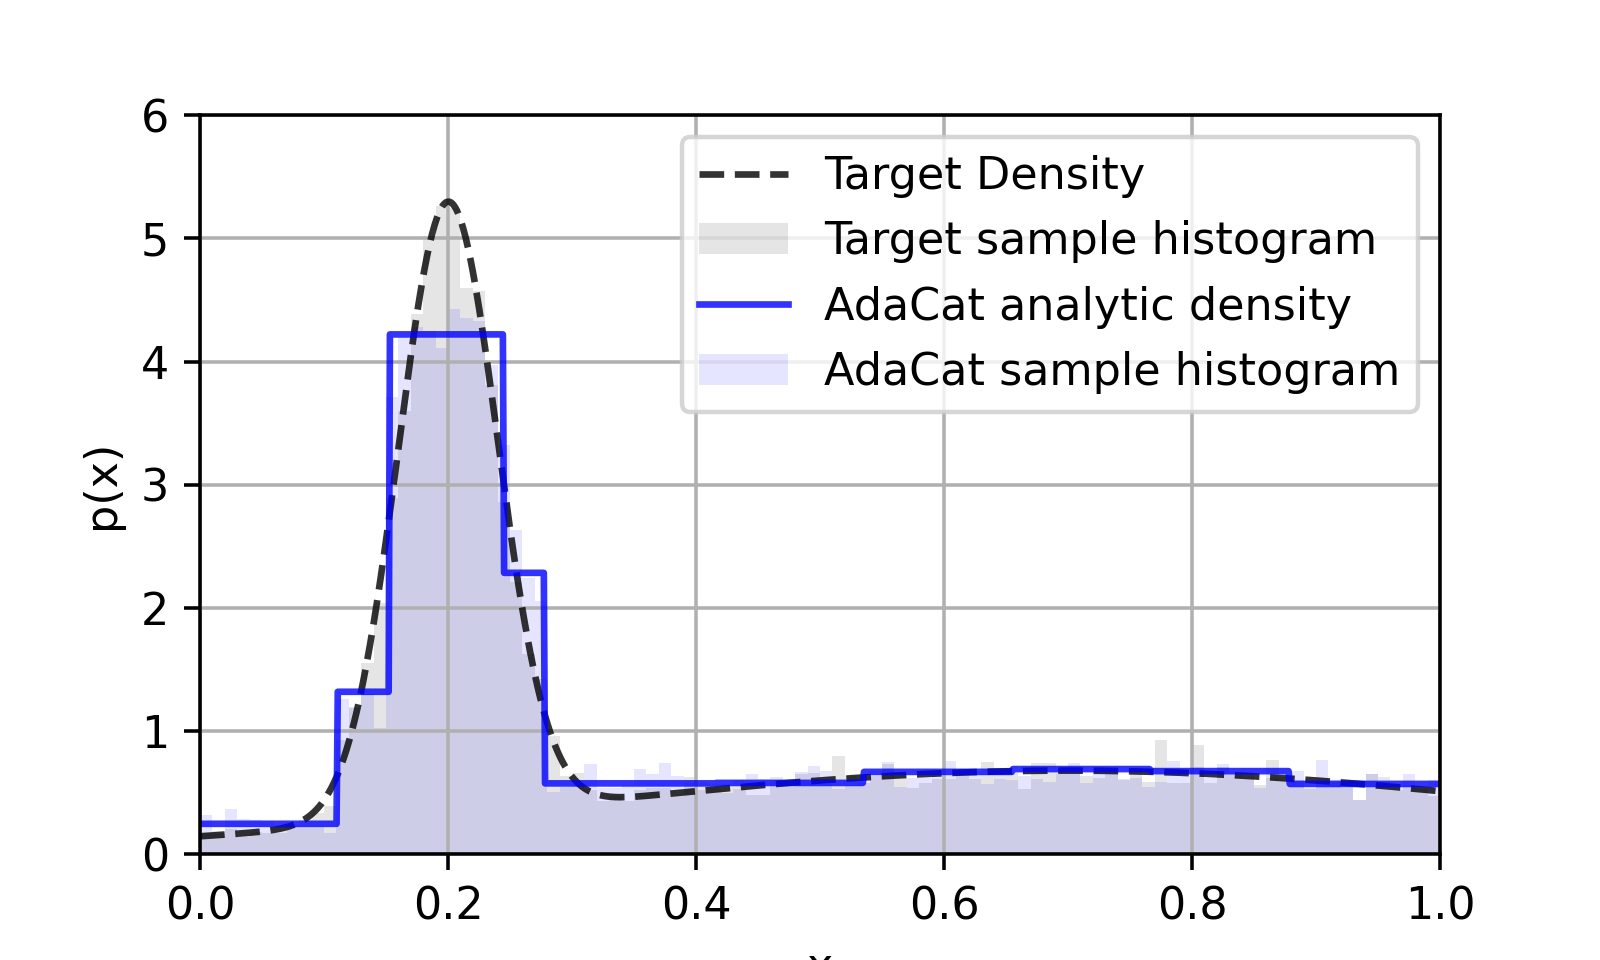

In [3]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=160)  # create a plot here. It will get updated when running the cell below.

In [4]:
optimizer = optax.adam(0.01)
opt_state = optimizer.init(params)

@partial(jax.jit, static_argnames=['optimizer'])
def step(samples, params, optimizer, opt_state):
    
    def loss_fn(params):
        d = Adacat(params["w_logits"], params["h_logits"], smooth_coeff=0.001)
        loss = -d.log_prob(samples).mean()
        return loss
    
    loss = loss_fn(params)
    grads = jax.grad(loss_fn)(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    
    return params, loss, opt_state
    
for _ in range(1, 3001):
    
    key, rng, vrng = jax.random.split(key, 3)
    
    samples = sample_mixture(rng, (200,), g1, g2)
    
    params, loss, opt_state = step(samples, params, optimizer, opt_state)
    
    print("\rIt: {:05d}, \tsm_loss: {:.03f}".format(_, loss), end="")
    
    if _ % 100 == 0: visualize(vrng, ax, True, params); fig.canvas.draw()
    
print("\nDone.")

It: 03000, 	sm_loss: -0.274
Done.
